<a href="https://colab.research.google.com/github/reetikesh17/GA_Steganography/blob/main/GA_Steganography.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install python-docx
!pip install crcmod
!pip install scikit-image

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 253.0/253.0 kB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.7/89.7 kB 3.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for crcmod: filename=crcmod-1.7-cp312-cp312-linux_x86_64.whl size=31833 sha256=fc02d701de5bb38cbbcf7b7f954d22b88f83b4a185d55f1cae1be3bb69da30ae
  Stored in directory: /root/.cache/pip/wheels/76/08/0b/caa8b1380122cbfe6a03eaccbec0f63c67e619af4e30ca5e2a
Successfully built crcmod


In [ ]:
import torch
import cv2
import random
from docx import Document
import numpy as np
import crcmod
from tqdm import tqdm
from google.colab import files
import os
from docx.shared import Pt
from skimage.metrics import structural_similarity as ssim
from scipy import stats

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def file_to_bit_tensor(file_path, device='cuda'):
    doc = Document(file_path)
    content = '\n'.join(p.text for p in doc.paragraphs if p.text.strip())
    if not content:
        raise ValueError("Document is empty or contains no text")

    byte_data = content.encode('utf-8', errors='replace')
    crc16 = crcmod.predefined.mkCrcFun('crc-16')
    crc_value = crc16(byte_data)
    crc_bits = bin(crc_value)[2:].zfill(16)
    bit_stream = ''.join(f"{byte:08b}" for byte in byte_data) + crc_bits
    while len(bit_stream) % 3 != 0:
        bit_stream += '0'

    bit_tensor = torch.tensor([int(b) for b in bit_stream], dtype=torch.uint8, device=device)
    return bit_tensor

def load_image_to_gpu(image_path):
    img = cv2.imread(image_path, cv2.IMREAD_COLOR)
    if img is None:
        raise ValueError("Could not load image")
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return torch.tensor(img, dtype=torch.uint8, device=device)

def calculate_complexity_gpu(img, coords, batch_size=5000):
    H, W, _ = img.shape
    coords = coords.long()
    all_scores = []

    for start in range(0, coords.shape[0], batch_size):
        end = min(start + batch_size, coords.shape[0])
        batch = coords[start:end]
        y, x, c = batch[:, 0], batch[:, 1], batch[:, 2]

        y_offsets = y.view(-1, 1) + torch.tensor([-1, 0, 1], device=device)
        x_offsets = x.view(-1, 1) + torch.tensor([-1, 0, 1], device=device)
        y_offsets = torch.clamp(y_offsets, 0, H - 1)
        x_offsets = torch.clamp(x_offsets, 0, W - 1)

        regions = img[y_offsets[:, :, None], x_offsets[:, None, :]].float()
        variance = torch.var(regions, dim=(1, 2, 3))

        flat = regions.view(regions.size(0), -1)
        hist = torch.histc(flat, bins=256, min=0, max=255)
        hist = hist / hist.sum() + 1e-10
        entropy = -torch.sum(hist * torch.log2(hist)).repeat(flat.size(0)).to(device)

        combined = 0.7 * variance + 0.3 * entropy
        all_scores.append(combined)

    return torch.cat(all_scores)

def genetic_algorithm(img, n_bits, pop_size=50, generations=200, mutation_rate=0.1, tournament_size=5):
    H, W, _ = img.shape
    n_pixels = int(n_bits * 3)

    population = torch.cat([
        torch.randint(0, H, (pop_size, n_pixels, 1), device=device),
        torch.randint(0, W, (pop_size, n_pixels, 1), device=device),
        torch.randint(0, 3, (pop_size, n_pixels, 1), device=device)
    ], dim=-1)

    best_individual = None
    best_fitness = -torch.inf

    for gen in tqdm(range(generations), desc="Genetic Algorithm"):
        flat_pop = population.view(-1, 3)
        fitness = calculate_complexity_gpu(img, flat_pop).view(pop_size, n_pixels)
        mean_fitness = torch.mean(fitness, dim=1)

        gen_best_idx = torch.argmax(mean_fitness)
        gen_best_fitness = mean_fitness[gen_best_idx]

        if gen_best_fitness > best_fitness:
            best_fitness = gen_best_fitness
            best_individual = population[gen_best_idx].clone()

        selected = []
        for _ in range(pop_size):
            contenders = torch.randint(0, pop_size, (tournament_size,))
            winner = contenders[torch.argmax(mean_fitness[contenders])]
            selected.append(population[winner])
        parents = torch.stack(selected)

        offspring = []
        cp = torch.randint(1, n_pixels - 1, (pop_size // 2,))
        for i in range(0, pop_size, 2):
            p1, p2 = parents[i], parents[i + 1]
            cut = cp[i // 2]
            c1 = torch.cat([p1[:cut], p2[cut:]], dim=0)
            c2 = torch.cat([p2[:cut], p1[cut:]], dim=0)
            offspring.extend([c1, c2])
        offspring = torch.stack(offspring)

        mutation_mask = torch.rand_like(offspring.float()) < mutation_rate
        mutation = torch.stack([
            torch.randint(-2, 3, (pop_size, n_pixels), device=device),
            torch.randint(-2, 3, (pop_size, n_pixels), device=device),
            torch.randint(0, 3, (pop_size, n_pixels), device=device)
        ], dim=-1)
        offspring = torch.where(mutation_mask, offspring + mutation, offspring)
        offspring[..., 0] = torch.clamp(offspring[..., 0], 0, H - 1)
        offspring[..., 1] = torch.clamp(offspring[..., 1], 0, W - 1)
        offspring[..., 2] = torch.clamp(offspring[..., 2], 0, 2)

        flat_offspring = offspring.view(-1, 3)
        offspring_fitness = calculate_complexity_gpu(img, flat_offspring).view(pop_size, n_pixels)
        mean_offspring_fitness = torch.mean(offspring_fitness, dim=1)
        worst_idx = torch.argmin(mean_offspring_fitness)
        offspring[worst_idx] = best_individual.clone()

        population = offspring

    final_fitness = calculate_complexity_gpu(img, best_individual)
    sorted_idx = torch.argsort(final_fitness, descending=True)

    seen = set()
    unique_coords = []
    for coord in best_individual[sorted_idx]:
        coord_tuple = (coord[0].item(), coord[1].item(), coord[2].item())
        if coord_tuple not in seen:
            unique_coords.append(coord)
            seen.add(coord_tuple)
        if len(unique_coords) == n_bits:
            break
    selected_pixels = torch.stack(unique_coords)

    return selected_pixels

def encode_on_gpu(image, coords, bit_tensor):
    H, W, _ = image.shape
    flat = image.view(-1, 3).clone()
    for i, (y, x, c) in enumerate(tqdm(coords, desc="Embedding Bits")):
        idx = y * W + x
        flat[idx, c] = (flat[idx, c] & 0xFE) | bit_tensor[i]
    return flat.view(H, W, 3)

def upload_and_get_path(label):
    print(label)
    uploaded = files.upload()
    return next(iter(uploaded))

if __name__ == "__main__":
    doc_path = upload_and_get_path("Upload your Word Document (.docx)")
    img_path = upload_and_get_path("Upload your Cover Image (.png or .jpg)")

    print("Converting document to bit tensor...")
    bit_tensor = file_to_bit_tensor(doc_path)

    print("Loading image to GPU...")
    img_gpu = load_image_to_gpu(img_path)

    print("Running genetic algorithm...")
    coords = genetic_algorithm(img_gpu, len(bit_tensor))

    print("Embedding data...")
    encoded_img = encode_on_gpu(img_gpu, coords, bit_tensor)

    print("Saving image and coordinates...")
    encoded_cpu = encoded_img.cpu().numpy()
    coords_cpu = coords.cpu().numpy()

    final_img = cv2.cvtColor(encoded_cpu, cv2.COLOR_RGB2BGR)
    cv2.imwrite("secure_image.png", final_img, [cv2.IMWRITE_PNG_COMPRESSION, 0])
    np.save("coordinates.npy", coords_cpu)

    print("Encoding complete. Downloading files...")
    files.download("secure_image.png")
    files.download("coordinates.npy")

Upload your Word Document (.docx)


Saving lorem 180k.docx to lorem 180k (2).docx
Upload your Cover Image (.png or .jpg)


Saving baboon.png to baboon.png
Converting document to bit tensor...
Loading image to GPU...
Running genetic algorithm...


Genetic Algorithm: 100%|██████████| 200/200 [18:12<00:00,  5.46s/it]


Embedding data...


Embedding Bits: 100%|██████████| 180618/180618 [00:26<00:00, 6704.35it/s]

Saving image and coordinates...
Encoding complete. Downloading files...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
def load_image_to_gpu(image_path):
    img = cv2.imread(image_path, cv2.IMREAD_COLOR)
    if img is None:
        raise ValueError("Could not load image")
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return torch.tensor(img, dtype=torch.uint8, device=device)

def extract_bits_from_image(image, coords):
    H, W, _ = image.shape
    coords = torch.tensor(coords, dtype=torch.long, device=device)

    y = coords[:, 0]
    x = coords[:, 1]
    c = coords[:, 2]

    flat_idx = y * W + x
    flat = image.view(-1, 3)
    bits = (flat[flat_idx, c] & 1).to(torch.uint8)
    return bits

def bits_to_bytes(bit_tensor):
    total_bits = bit_tensor.shape[0]
    remainder = total_bits % 8
    if remainder != 0:
        bit_tensor = bit_tensor[:-remainder]

    bit_tensor = bit_tensor.view(-1, 8)
    byte_vals = (bit_tensor * (2 ** torch.arange(7, -1, -1, device=bit_tensor.device))).sum(dim=1)
    return byte_vals.cpu().numpy().astype(np.uint8)

def decode_bitstream(bit_tensor):
    byte_array = bits_to_bytes(bit_tensor)
    if len(byte_array) < 2:
        raise ValueError("Not enough data to decode")

    data = byte_array[:-2]
    crc_bytes = byte_array[-2:]
    embedded_crc = int.from_bytes(crc_bytes, byteorder='big')

    crc16 = crcmod.predefined.mkCrcFun('crc-16')
    computed_crc = crc16(data)

    if computed_crc != embedded_crc:
        raise ValueError(f"CRC check failed! Computed: {computed_crc:04X}, Expected: {embedded_crc:04X}")

    decoded_str = data.tobytes().decode('utf-8', errors='replace')
    return decoded_str

def save_to_docx(message, filename="extracted_message.docx"):
    doc = Document()
    style = doc.styles['Normal']
    font = style.font
    font.name = 'Arial'
    font.size = Pt(11)

    paragraphs = message.split('\n')
    for para in paragraphs:
        if para.strip():
            doc.add_paragraph(para)

    doc.save(filename)
    return filename

def upload_and_get_path(label):
    print(label)
    uploaded = files.upload()
    return next(iter(uploaded))

if __name__ == "__main__":
    print("Upload the Encoded Image (e.g. secure_image.png)")
    img_path = upload_and_get_path("")

    print("Upload the Coordinates File (coordinates.npy)")
    coords_path = upload_and_get_path("")

    print("Loading image to GPU...")
    img_gpu = load_image_to_gpu(img_path)

    print("Loading coordinates...")
    coords = np.load(coords_path)

    print("Extracting LSBs...")
    bits = extract_bits_from_image(img_gpu, coords)

    print("Decoding bitstream...")
    try:
        message = decode_bitstream(bits)
        print("\n Message successfully extracted!\n")
        print("Secret Message:\n" + "="*40)
        print(message)
        print("="*40)

        docx_filename = save_to_docx(message)
        print(f"\nSaving extracted message to {docx_filename}...")
        files.download(docx_filename)

    except Exception as e:
        print(f"{str(e)}")


Upload the Encoded Image (e.g. secure_image.png)



Saving baboon.png to baboon (3).png
Upload the Coordinates File (coordinates.npy)



Saving coordinates (4).npy to coordinates (4) (2).npy
Loading image to GPU...
Loading coordinates...
Extracting LSBs...
Decoding bitstream...
CRC check failed! Computed: 2EF2, Expected: 59DF


In [ ]:
def calculate_metrics(original_img, stego_img, coords):
    if original_img.shape != stego_img.shape:
        raise ValueError("Image dimensions don't match")

    payload_bits = len(coords)

    orig = original_img.astype(np.float32)
    stego = stego_img.astype(np.float32)

    diff = cv2.absdiff(orig, stego)
    mse_val = np.mean(diff ** 2)
    rmse_val = np.sqrt(mse_val)

    if mse_val == 0:
        psnr_val = float('inf')
    else:
        psnr_val = 20 * np.log10(255 / np.sqrt(mse_val))
    signal_power = np.mean(orig ** 2)
    noise_power = mse_val
    snr_val = 10 * np.log10(signal_power / noise_power) if noise_power > 0 else float('inf')
    min_dim = min(original_img.shape[:2])
    win_size = min(7, min_dim) if min_dim % 2 == 1 else min(7, min_dim - 1)
    ssim_val = ssim(orig, stego, win_size=win_size, channel_axis=2, data_range=255)
    ncc_val = np.sum(orig * stego) / np.sqrt(np.sum(orig ** 2) * np.sum(stego ** 2))

    def image_entropy(img):
        hist = cv2.calcHist([img], [0], None, [256], [0,256])
        hist = hist / hist.sum()
        return -np.sum(hist * np.log2(hist + 1e-10))

    entropy_orig = image_entropy(original_img)
    entropy_stego = image_entropy(stego_img)
    mean_orig = np.mean(original_img)
    mean_stego = np.mean(stego_img)
    median_orig = np.median(original_img)
    median_stego = np.median(stego_img)
    mode_orig = stats.mode(original_img.flatten(), keepdims=True).mode[0]
    mode_stego = stats.mode(stego_img.flatten(), keepdims=True).mode[0]

    def chi_square_test(img, channel=0):
        hist = cv2.calcHist([img[:,:,channel]], [0], None, [128], [0,256])
        pairs = (hist[::2] + hist[1::2]) / 2
        mask = pairs > 0
        chi = np.sum((hist[::2][mask] - pairs[mask])**2 / pairs[mask])
        return chi

    chi_orig = chi_square_test(original_img)
    chi_stego = chi_square_test(stego_img)

    height, width, _ = original_img.shape
    total_pixels = height * width * 3
    payload_bpp = payload_bits / total_pixels

    return {
        "MSE": float(mse_val),
        "RMSE": float(rmse_val),
        "PSNR": float(psnr_val),
        "SNR": float(snr_val),
        "SSIM": float(ssim_val),
        "NCC": float(ncc_val),
        "Entropy (Original)": float(entropy_orig),
        "Entropy (Stego)": float(entropy_stego),
        "Mean (Original)": float(mean_orig),
        "Mean (Stego)": float(mean_stego),
        "Median (Original)": float(median_orig),
        "Median (Stego)": float(median_stego),
        "Mode (Original)": float(mode_orig),
        "Mode (Stego)": float(mode_stego),
        "Chi-Square (Original)": float(chi_orig),
        "Chi-Square (Stego)": float(chi_stego),
        "Payload (bits)": int(payload_bits),
        "Payload (bpp)": float(payload_bpp)
    }

def upload_image(label):
    print(label)
    uploaded = files.upload()
    filename = next(iter(uploaded))
    img = cv2.imread(filename)
    if img is None:
        raise ValueError(f"Could not load image: {filename}")
    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

def upload_coordinates(label):
    print(label)
    uploaded = files.upload()
    filename = next(iter(uploaded))
    return np.load(filename)

if __name__ == "__main__":
    print("=== Steganography Quality Metrics Calculator ===")
    print("Please upload your files:")

    try:
        original_img = upload_image("1. Upload ORIGINAL image:")
        stego_img = upload_image("2. Upload STEGO image:")
        coords = upload_coordinates("3. Upload COORDINATES file (coordinates.npy):")

        metrics = calculate_metrics(original_img, stego_img, coords)

        print("\n=== Steganography Quality Metrics ===")
        print("="*60)
        for key, value in metrics.items():
            if isinstance(value, float):
                if np.isinf(value):
                    print(f"{key:<25}: Infinite (perfect match)")
                else:
                    print(f"{key:<25}: {value:.6f}")
            else:
                print(f"{key:<25}: {value}")
        print("="*60)

    except Exception as e:
        print(f"\nError: {str(e)}")
        print("Please check your input files and try again.")


=== Steganography Quality Metrics Calculator ===
Please upload your files:
1. Upload ORIGINAL image:


Saving baboon.png to baboon (1).png
2. Upload STEGO image:


Saving secure_image (3).png to secure_image (3) (12).png
3. Upload COORDINATES file (coordinates.npy):


Saving coordinates (4).npy to coordinates (4) (1).npy

=== Steganography Quality Metrics ===
MSE                      : 0.114726
RMSE                     : 0.338712
PSNR                     : 57.534195
SNR                      : 52.224735
SSIM                     : 0.999779
NCC                      : 0.999997
Entropy (Original)       : 7.706672
Entropy (Stego)          : 7.706671
Mean (Original)          : 126.455739
Mean (Stego)             : 126.449262
Median (Original)        : 121.000000
Median (Stego)           : 121.000000
Mode (Original)          : 88.000000
Mode (Stego)             : 88.000000
Chi-Square (Original)    : 344.534668
Chi-Square (Stego)       : 344.534668
Payload (bits)           : 180618
Payload (bpp)            : 0.229668


Upload Original image


Saving baboon.png to baboon (2).png
Upload Stego image


Saving secure_image (3).png to secure_image (3) (13).png


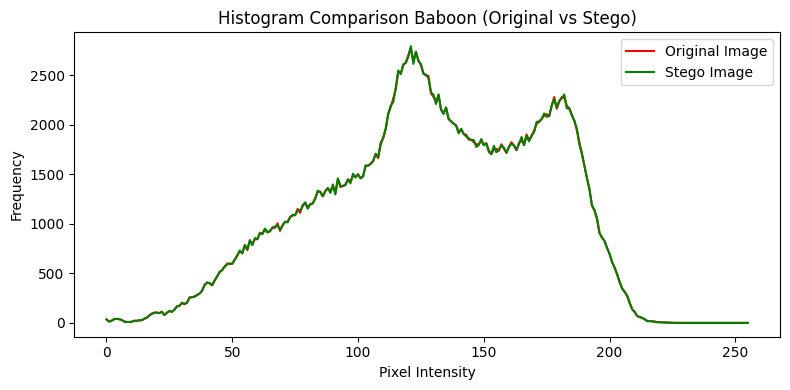

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from google.colab import files

print("Upload Original image")
uploaded = files.upload()
original_img_path = list(uploaded.keys())[0]

print("Upload Stego image")
uploaded = files.upload()
stego_img_path = list(uploaded.keys())[0]

original = cv2.imread(original_img_path)
stego = cv2.imread(stego_img_path)

if original is None:
    raise FileNotFoundError("Original image not found.")
if stego is None:
    raise FileNotFoundError("Stego image not found.")

original_gray = cv2.cvtColor(original, cv2.COLOR_BGR2GRAY)
stego_gray = cv2.cvtColor(stego, cv2.COLOR_BGR2GRAY)

hist_original = cv2.calcHist([original_gray], [0], None, [256], [0, 256]).flatten()
hist_stego = cv2.calcHist([stego_gray], [0], None, [256], [0, 256]).flatten()

plt.figure(figsize=(8, 4))
plt.plot(hist_original, color='red', label='Original Image')
plt.plot(hist_stego, color='green', label='Stego Image')
plt.title('Histogram Comparison Baboon (Original vs Stego)')
plt.xlabel('Pixel Intensity')
plt.ylabel('Frequency')
plt.legend()
plt.grid(False)
plt.tight_layout()
plt.show()


Upload Original image


Saving Lenna.png to Lenna.png
Upload Stego image


Saving secure_image (3).png to secure_image (3).png


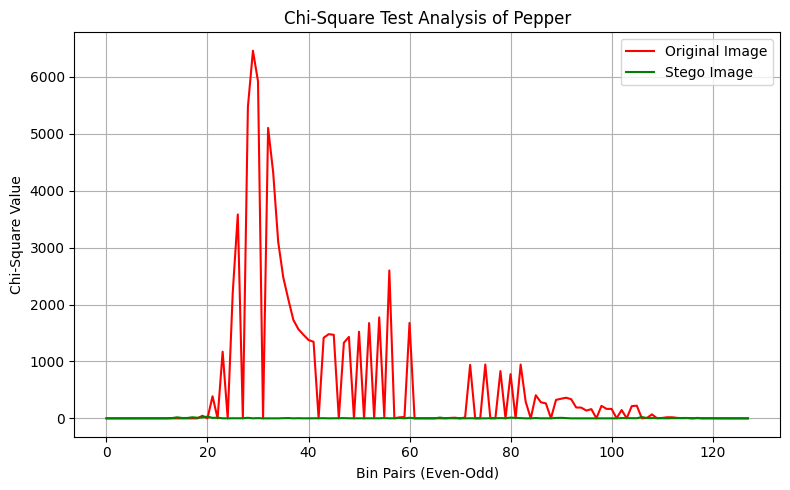

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from google.colab import files

# Upload images
print("Upload Original image")
uploaded = files.upload()
original_img_path = list(uploaded.keys())[0]

print("Upload Stego image")
uploaded = files.upload()
stego_img_path = list(uploaded.keys())[0]

# Read images
original = cv2.imread(original_img_path, cv2.IMREAD_GRAYSCALE)
stego = cv2.imread(stego_img_path, cv2.IMREAD_GRAYSCALE)

if original is None:
    raise FileNotFoundError("Original image not found.")
if stego is None:
    raise FileNotFoundError("Stego image not found.")

# Function: Chi-Square test for LSB analysis
def chi_square_test(img):
    hist = cv2.calcHist([img], [0], None, [256], [0, 256]).flatten()
    chi_values = []

    for i in range(0, 256, 2):
        Oe = hist[i]     # observed even bin
        Oo = hist[i+1]   # observed odd bin
        if Oe + Oo == 0:
            chi_values.append(0)
        else:
            E = (Oe + Oo) / 2.0
            chi = ((Oe - E) ** 2) / E + ((Oo - E) ** 2) / E
            chi_values.append(chi)

    return np.array(chi_values)

# Run chi-square test
chi_original = chi_square_test(original)
chi_stego = chi_square_test(stego)

# Plot Chi-Square comparison
plt.figure(figsize=(8, 5))
plt.plot(chi_original, color='red', label="Original Image")
plt.plot(chi_stego, color='green', label="Stego Image")
plt.title("Chi-Square Test Analysis of Pepper")
plt.xlabel("Bin Pairs (Even-Odd)")
plt.ylabel("Chi-Square Value")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
